## Objective:
To build a multi-label model that's capable of detecting different types of toxicity of like `threats`, `obscenity`, `insults`, and identity-based comments from Wikipedia’s talk page edits.

## Project Description:
The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). 

In [0]:
import numpy as np
import pandas as pd 
import string

# NLP
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

# keras
import keras
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import seaborn as sns
%matplotlib inline

# Configure seaborn
sns.set_style('white',{"xtick.major.size": 5, "ytick.major.size": 5})
plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 18

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [0]:
# Text Annotation
def text_annotate(cnt):
    for i in cnt.patches:
        height = i.get_height()
        cnt.text(i.get_x() + i.get_width()/2., height,'%d' % int(height),ha='center',va='bottom')

def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [0]:
folder_path = '/content/drive/My Drive/Toxic Comment Classification/'

train = pd.read_csv(f'{folder_path}train.csv')
test = pd.read_csv(f'{folder_path}test.csv')
submission = pd.read_csv(f'{folder_path}sample_submission.csv')

## Exploratory Data Analysis (EDA)

### Data Overview

Training and test sets both contain following fields.

- id:  a random unique string
- comment_text: the text of the comment

It consists of large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are: 
- toxic 
- severe_toxic
- obscene 
- threat 
- insult 
- identity_hate



- Text classification problem, classify whether it is toxic.
- The column `comment_text` contains the comments text and it will be the main feature.
- All the remaining columns except `id` will be the target variable to predict.
- Target variables are binary encoded (one hot encoded) & all zeros represents a clean comment.
- A single comments can belong to multiple toxicity classes

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# List the fields in our dataframe
print(train.dtypes)

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


In [6]:
print(train.shape, test.shape)

(159571, 8) (153164, 2)


The training set consists of labeled `159,571` comments (observations) and test set `153,164`

### Missing Values

In [7]:
def null_percentage(column):
    df_name = column.name
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    print('%d%% or %d missing from %s column.' % 
          (perc, nans, df_name))

def check_null(df, columns):
    for col in columns:
        null_percentage(df[col])
        
check_null(train, train.columns)

0% or 0 missing from id column.
0% or 0 missing from comment_text column.
0% or 0 missing from toxic column.
0% or 0 missing from severe_toxic column.
0% or 0 missing from obscene column.
0% or 0 missing from threat column.
0% or 0 missing from insult column.
0% or 0 missing from identity_hate column.


**Non-Toxic/ No Labeled Comments**

Create a `'clean'` label so we can see how many comments have no labels. 

In [8]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Adding 'clean' columns if there is no '1' in columns
train['clean'] = (train[label_cols].max(axis=1) == 0).astype(int)
label_cols.append('clean')
categories = label_cols.copy()

print(train.shape)
print(train.columns.values)

(159571, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'clean']


Now we count the number of comments under each label.

In [9]:
# Dropping id and comment_text
comment_types = train.drop(['id','comment_text'], axis=1)

# Calculating total count of each category comments
counts = []
categories = list(comment_types.columns.values)
for i in categories:
    counts.append((i, comment_types[i].sum()))
cnt_category = pd.DataFrame(counts, columns=['Category', 'Count'])
cnt_category.sort_values('Count', ascending=False)

,Category,Count
6,clean,143346
0,toxic,15294
2,obscene,8449
4,insult,7877
1,severe_toxic,1595
5,identity_hate,1405
3,threat,478


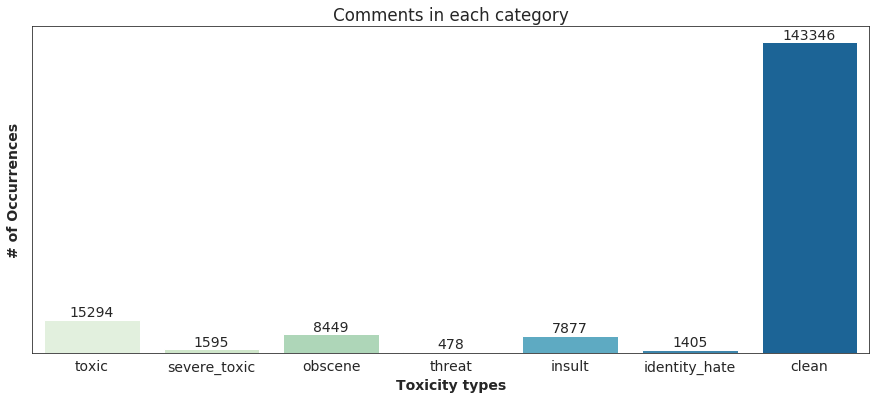

In [10]:
cnt = sns.barplot(x='Category', y='Count', data=cnt_category, palette="GnBu")
text_annotate(cnt)
cnt.set_yticklabels('')
plt.title("Comments in each category")
plt.ylabel('# of Occurrences')
plt.xlabel('Toxicity types')
plt.show()

The `toxic` comments are more common while `threat` is least occuring class. This shows that the number of comments in each category is extremely imbalanced between the clean and unclean comments. And with in unclean comments, there is imbalance between the types of toxicity. We can further check whether each comment has been tagged or not?



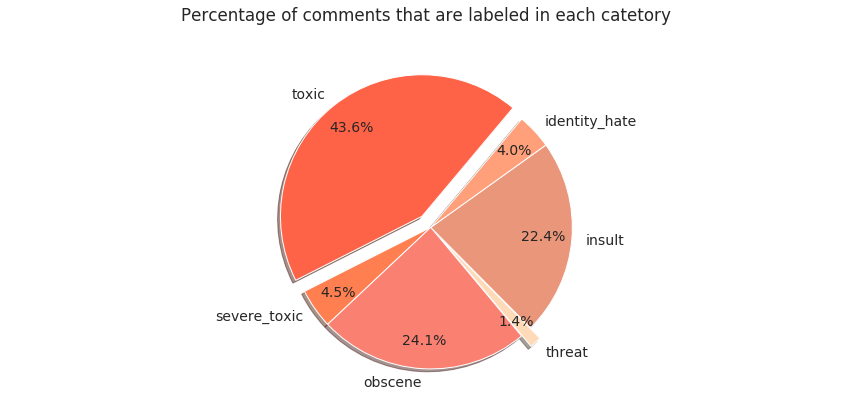

In [11]:
category_freq = cnt_category['Count'][:-1].values
colors = ['tomato', 'coral', 'salmon', 'peachpuff', 'darksalmon','lightsalmon']
explode = (0.1, 0, 0, 0.1, 0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(category_freq, 
        colors = colors,
        labels=label_cols[:-1], 
        autopct='%1.1f%%', 
        startangle=50, 
        explode=explode,
        pctdistance=0.8, 
        #labeldistance=1.1, 
        radius=1,
        shadow=True
        )
ax1.axis('equal') 
plt.title("Percentage of comments that are labeled in each catetory",y=1.1)
plt.show()  

**Multi-tagging**

Let's check how many comments have multiple tags.

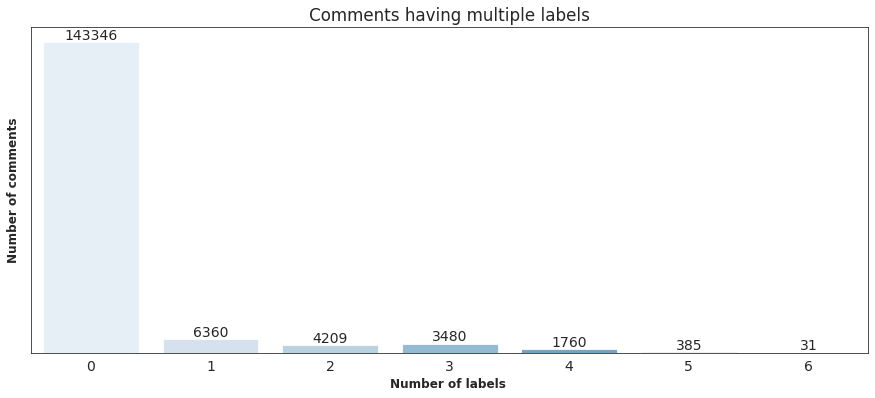

In [12]:
x = train.iloc[:,2:8].sum(axis=1).value_counts()

# plt.figure(figsize=(10,7.5))
ax = sns.barplot(x.index, x.values, alpha=0.8,palette="Blues")
plt.title("Comments having multiple labels")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of labels ', fontsize=12)
ax.set_yticklabels('')

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Counting the number of comments having multiple labels.

The maximum number of tags for a bad comment is `6` it will belong to all six classes.


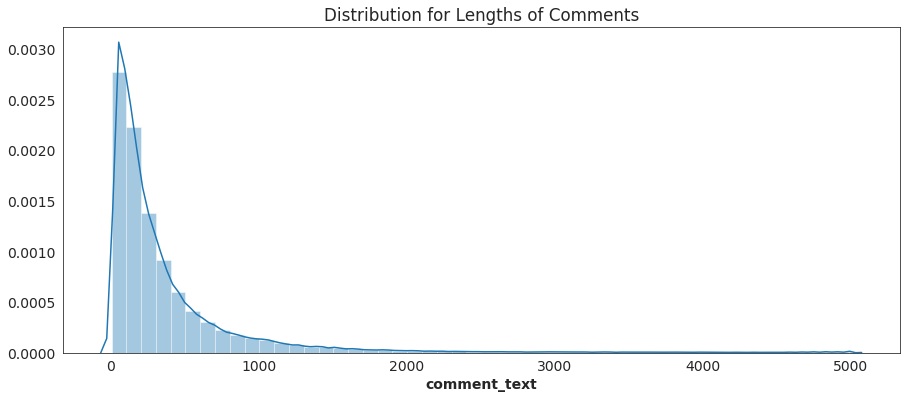

In [13]:
lens = train['comment_text'].str.len()
sns.distplot(lens)
plt.title("Distribution for Lengths of Comments")
plt.show()

This indicates that most of the comments are of lengths less than 500, while some are of length 5000 as well.

In [14]:
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total Labeled Tags = ",train.iloc[:,2:8].sum().sum())

Total comments =  159571
Total clean comments =  143346
Total Labeled Tags =  35098


16,225 out of 159,571 comments, or **10.2%**, are classified as some category of `toxicity`.

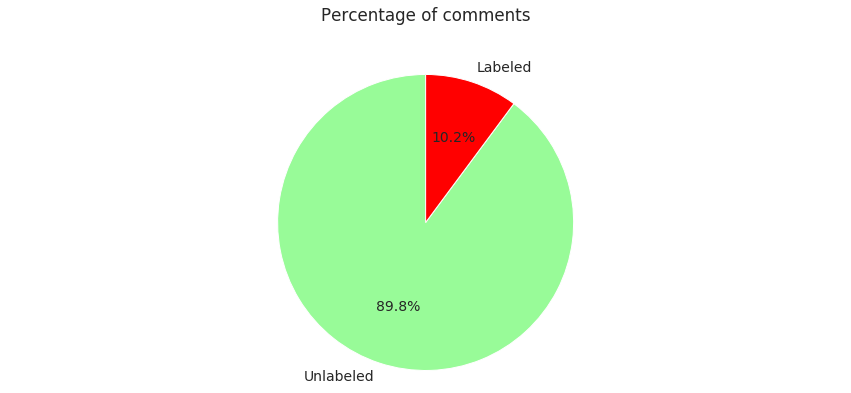

In [15]:
nolabeled = 0
labeled = 0
for i in range(len(train)):
    count = 0
    for j in range(2,8):
        count = count + train.iloc[i,j]
    if count == 0:
        nolabeled +=1
    else:
        labeled +=1   
        
label2 = ['Unlabeled', 'Labeled']
size = [nolabeled, labeled]
fig1, ax1 = plt.subplots()
colors = ['palegreen','red']
ax1.pie(size, colors=colors, labels=label2, autopct='%1.1f%%',startangle=90)
ax1.axis('equal') 
plt.title("Percentage of comments",y=1.1)
plt.show()

Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a look at `toxic` with other tags.

In [16]:
# Crosstab
main_col="toxic"
corr_mats=[]
# filter train dataframe by removing clean comments
temp_df = train.iloc[:,2:-1]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

# cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

### Label/Target Distribution

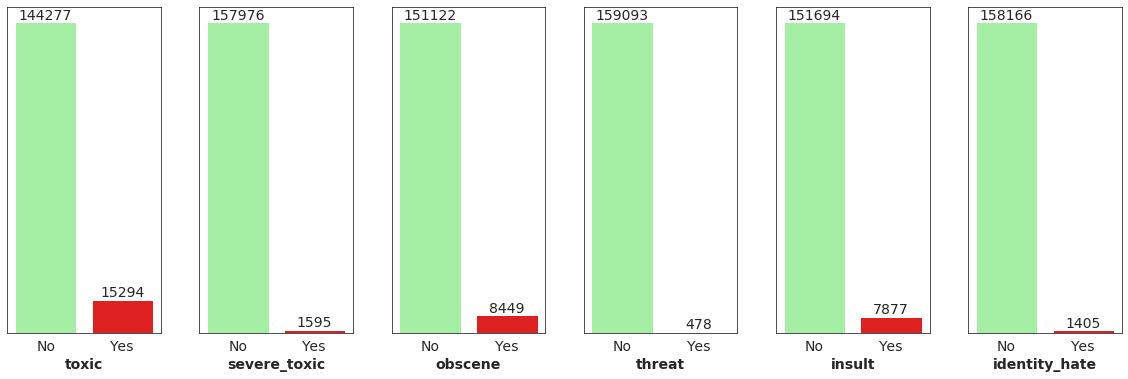

In [17]:
target_var = label_cols[:6]
def dist_plot(df, labels, n_rows, n_cols):
    fig = plt.figure(figsize=(18,6))
    for i, labels in enumerate(labels):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        cnt= sns.countplot(labels, data=df, palette=['palegreen', 'red'])
        text_annotate(cnt)
        cnt.set_yticklabels('')
        cnt.set_ylabel('')
        cnt.set_xticklabels(['No','Yes'])
dist_plot(train, target_var, 1, 6)

# Subplots spacing
plt.subplots_adjust(left=0.04, right=0.9, wspace=0.25, hspace=0.35)

## Correlation Matrix
Checking correlation between various label properties.
- `'toxic'` is clearly correlated with `'obscene'` and `'insult'` (0.68 and 0.65)
- `'toxic'` and `'severe_toxic'` are only got a 0.31 correlation factor
- `'insult'` and `'obscene'` have a correlation factor of 0.74

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

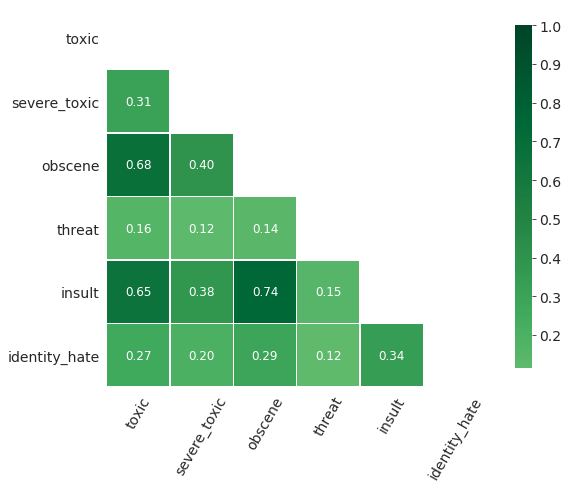

In [18]:
# Compute the correlation matrix
corr = train.iloc[:,2:8].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap='YlGn', vmax=1,center=0, fmt='.2f',
            square=True, linewidths=.5, annot_kws={'size': 12}, cbar_kws={'shrink': .9})
plt.xticks(rotation=60) 

### Venn Diagram
The three top *common* labels are :
- toxic
- obscene
- insult

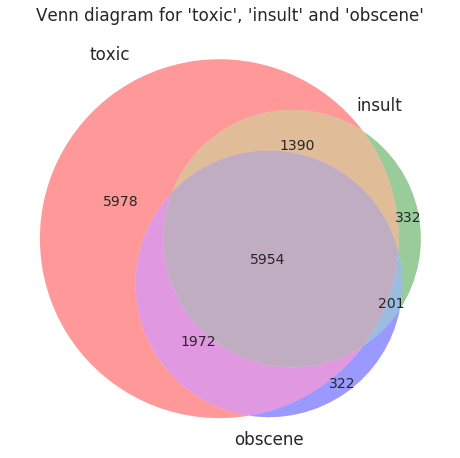

In [19]:
t = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 0)].shape[0]
i = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
o = train[(train['toxic'] == 0) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]

t_i = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
t_o = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]
i_o = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]

t_i_o = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

This venn diagram demonstrates the correlations found in the previous visualization.

- There is only a small part of `'insult'` and `'obscene'` that are not also labelled 'toxic'.
- `3610` comments are labelled with all 3 categories.

Let's take a look at the Venn diagram between `'toxic'` and `'severe_toxic'`.

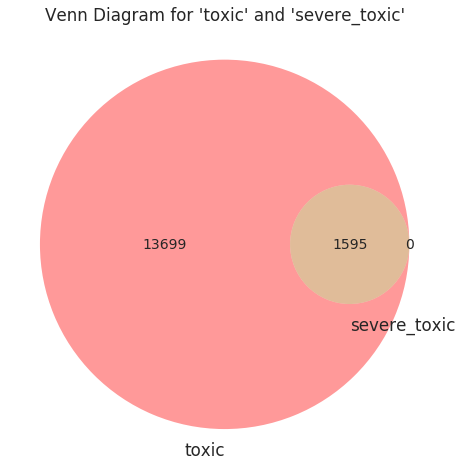

In [20]:
t = train[(train['toxic'] == 1) & (train['severe_toxic'] == 0)].shape[0]
s = train[(train['toxic'] == 0) & (train['severe_toxic'] == 1)].shape[0]
t_s = train[(train['toxic'] == 1) & (train['severe_toxic'] == 1)].shape[0]

# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn Diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (t, s, t_s), 
      set_labels=('toxic', 'severe_toxic'))
plt.show()

### Words Analysis
- WordCloud representation of most used words in each category of comments.

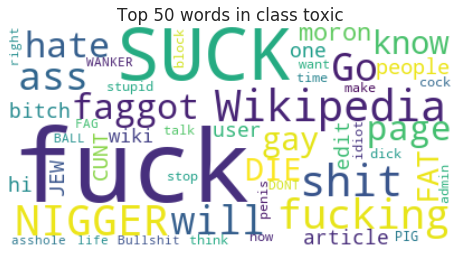

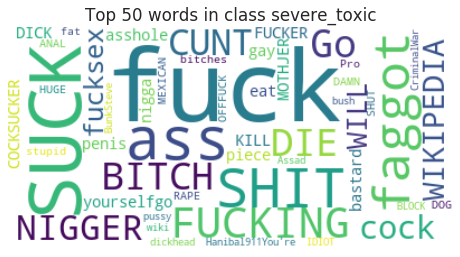

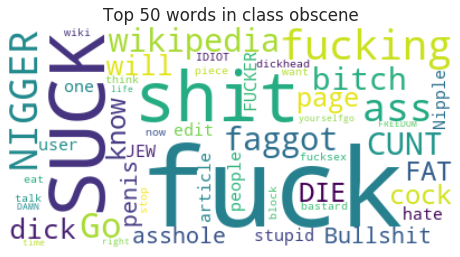

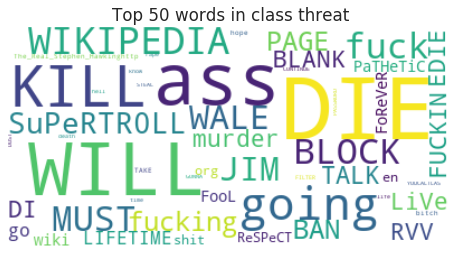

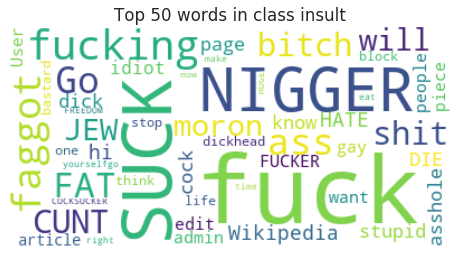

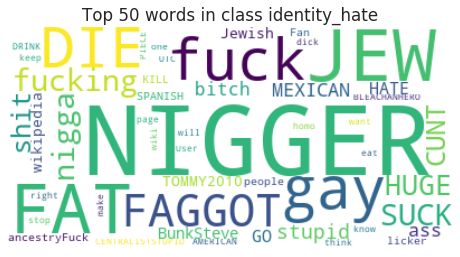

In [21]:
def class_wordcloud(dataframe, label, max_words):
    # data preprocessing: concatenate all reviews per class
    text = " ".join(x for x in dataframe[dataframe[label]==1].comment_text)

    # create and generate a word cloud image
    wordcloud = WordCloud(max_words=max_words, background_color="white", collocations=False).generate(text)

    # display the generated image
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Top {max_words} words in class {label}")
    plt.show()
for label in target_var:
    class_wordcloud(train, label, 50)